In [1]:
using FunctionalCollections
using Iterators
using Pipe
using Compat

macro printval(ee)
    ee_expr = @sprintf "%s" string(ee)
    esc(:(println($ee_expr," = ", $ee)))
end

macro pz(ee)
    ee_expr = @sprintf "%s" string(ee)
    esc(:(println($ee_expr,"\t\t",typeof($ee), "\t", size($ee))))
end

push!(LOAD_PATH, ".")
push!(LOAD_PATH, "../util/")
using DataStructures
using DataStructuresExtended
using JLD
using DataFrames

In [238]:
function groupby_value(fn::Function, xs)
    key_type = typeof(fn(first(xs)))
    group_type = Vector{typeof(first(xs))}
    groups = Dict{key_type, group_type}()
    
    for x in xs
        key = fn(x)
        group = get!(()->group_type(), groups, key)
        push!(group, x)
    end
    groups
end
function round_tbl(data::DataFrame, places=2)
    ret = copy(data)
    for (ii,column) in enumerate(ret.columns)
        if typeof(column[1])<:Number #hack
            ret.columns[ii] = round(column, places)
        end
    end
    ret
end


round_tbl (generic function with 2 methods)

In [3]:
OUTPUT_DIR = "../../documents_prepared/Journal\ Papers/SumResynthesis/data/"

"../../documents_prepared/Journal Papers/SumResynthesis/data/"

In [4]:
function jaccard_index(aa::DataStructures.Accumulator,bb::DataStructures.Accumulator)
    sum(intersect(aa,bb))/sum(union(aa,bb))
end

function jaccard_index(aa,bb)
    length(intersect(aa,bb))/length(union(aa,bb))
end

jaccard_index (generic function with 2 methods)

In [5]:
function precision(actual::DataStructures.Accumulator,reference::DataStructures.Accumulator)
    sum(intersect(actual,reference))/sum(actual)
end
function recall(actual::DataStructures.Accumulator,reference::DataStructures.Accumulator)
    sum(intersect(actual,reference))/sum(reference)
end

recall (generic function with 1 method)

In [10]:

function flatten_blocked_records{T<:Number, V}(records::Dict{T,V})  
    rec_types = @pipe records |> values |> map(typeof,_) |> union
    rec_type = length(rec_types)==1 ? rec_types[1] : V
    ret = rec_type() #Construct it, it is some form of vector, or we will error soon
    sizehint!(ret) = sum([length(r) for r in values(records)])
    
    sorted_keys = @pipe records |> keys |> collect |> sort
    for key in sorted_keys
        push!(ret, records[key]...)
    end
    ret
end

function flatten_raw_blocked_records{T,V}(records::Dict{T,V})  
    key_types = @pipe records |> keys|> map(parse,_) |> map(typeof,_) |> union
    @assert length(key_types)==1
    key_type =  key_types[1]
    
    rec_types = @pipe records |> values |> map(typeof,_) |> union
    rec_type = length(rec_types)==1 ? rec_types[1] : V
    flatten_blocked_records(Dict(Pair{key_type, rec_type}[parse(k)=>v for (k,v) in records]))
end

flatten_raw_blocked_records (generic function with 1 method)

In [50]:

#books_glove300cityblock_raw = load("results/bags/books_corpus_0.001_of_test_glove300_cityblock.jld","4")
books_0_001_glove300_raw = flatten_raw_blocked_records(load("results/bags/books_corpus_0.001_of_test_glove300.jld"))
#books_001o_glove300_raw = flatten_raw_blocked_records(load("results/bags/books_corpus_0.01_of_test_glove300.jld"))
#brown_glove300_raw = load("results/bags/brown_glove300_res.jld", "res")
#brown_glove200_raw = load("results/bags/brown_glove200_res.jld", "res")
#brown_glove100_raw = load("results/bags/brown_glove100_res.jld", "res")
#brown_glove50_raw = load("results/bags/brown_glove50_res.jld", "res")

6677-element Array{Tuple{Array{ASCIIString,1},Array{ASCIIString,1},Float32},1}:
 (ASCIIString["``","you","would","destroy","a","book","that","even","the","quran","calls","holy","?","''"],ASCIIString["``","you","holy","would","book","that","a","quran","destroy","calls","the","even","?","''"],-2.5348536f-6)                                                                                                                                                             
 (ASCIIString["im","glad","that","i","left","henderson","."],ASCIIString["i","left","im","that","henderson","glad","."],-1.4708529f-6)                                                                                                                                                                                                                                                         
 (ASCIIString["he","ran","around","the","student","apartments","yelling","fire",",","fire","!"],ASCIIString["fire","fire","he","!","around","ran","apart

In [ ]:
@assert all([rset[1] for rset in brown_glove50_raw] .== [rset[1] for rset in brown_glove300_raw])
@assert all([rset[1] for rset in brown_glove50_raw] .== [rset[1] for rset in brown_glove200_raw])
@assert all([rset[1] for rset in brown_glove50_raw] .== [rset[1] for rset in brown_glove100_raw])

In [60]:
bag_res = DataFrame()
bag_res[:ground] = [counter(rset[1]) for rset in books_0_001_glove300_raw]
bag_res[:ground_len] = Int[sum(ss) for ss in bag_res[:ground]]
exp_names = ASCIIString[]
for raw_name in ["books_0_001_glove300_raw"]#"brown_glove50_raw","brown_glove100_raw", "brown_glove200_raw", "brown_glove300_raw"]
    colname = join(split(raw_name,"_")[1:end-2],"_")
    push!(exp_names, colname)
    raw = eval(raw_name|>Symbol)
    bag_res[colname*"_actual"|> Symbol] = [counter(rset[2]) for rset in raw]
    #bag_res[colname*"_distance"|> Symbol] = Float64[-1*rset[3] for rset in raw]
end

#bag_res

In [61]:
for exp_name in exp_names
    actual = bag_res[exp_name*"_actual" |> symbol]
    bag_res[exp_name*"_perfect" |> symbol] = actual.==bag_res[:ground]
    bag_res[exp_name*"_jaccard" |> symbol] = map(jaccard_index, actual, bag_res[:ground])
    bag_res[exp_name*"_precision" |> symbol] = map(precision, actual, bag_res[:ground])
    bag_res[exp_name*"_recall" |> symbol] = map(recall, actual, bag_res[:ground])
end

In [62]:
bag_res.colindex |> keys

7-element Array{Symbol,1}:
 :ground               
 :ground_len           
 :books_0_001_actual   
 :books_0_001_perfect  
 :books_0_001_jaccard  
 :books_0_001_precision
 :books_0_001_recall   

In [239]:
keep_cols = @pipe (bag_res.colindex |> keys |> map(string,_)
                    |>filter(col -> contains(col,"jaccard") ||  contains(col,"perfect") ||  contains(col,"recall") ||  contains(col,"precision"),_)
                    |> map(Symbol,_))
len_scores = aggregate(bag_res[[:ground_len, keep_cols...]], :ground_len, mean)
sort!(len_scores)
writetable(OUTPUT_DIR*"selection_len_scores.csv", len_scores)
len_scores |> round_tbl

,ground_len,books_0_001_perfect_mean,books_0_001_jaccard_mean,books_0_001_precision_mean,books_0_001_recall_mean
1,1,1.0,1.0,1.0,1.0
2,2,1.0,1.0,1.0,1.0
3,3,1.0,1.0,1.0,1.0
4,4,1.0,1.0,1.0,1.0
5,5,0.99,0.99,0.99,1.0
6,6,0.99,1.0,1.0,1.0
7,7,0.97,0.99,0.99,0.99
8,8,0.96,0.98,0.99,0.99
9,9,0.96,0.99,0.99,0.99
10,10,0.91,0.97,0.98,0.99


In [240]:
cum_len_scores = DataFrame()
cum_len_scores[:max_ground_len] = bag_res[:ground_len] |> unique |> sort!
for col in keep_cols
    cum_len_scores[col] = Float64[ begin
            shortish_sents = bag_res[:ground_len] .<= max_len;
            bag_res[shortish_sents, col] |> mean
         end for max_len in cum_len_scores[:max_ground_len]]
end

writetable(OUTPUT_DIR*"selection_cum_len_scores.csv", cum_len_scores)
cum_len_scores |> round_tbl


,max_ground_len,books_0_001_perfect,books_0_001_jaccard,books_0_001_precision,books_0_001_recall
1,1,1.0,1.0,1.0,1.0
2,2,1.0,1.0,1.0,1.0
3,3,1.0,1.0,1.0,1.0
4,4,1.0,1.0,1.0,1.0
5,5,1.0,1.0,1.0,1.0
6,6,1.0,1.0,1.0,1.0
7,7,0.99,1.0,1.0,1.0
8,8,0.98,0.99,1.0,1.0
9,9,0.98,0.99,0.99,1.0
10,10,0.97,0.99,0.99,0.99


In [65]:
cum_len_scores[57,:]

,max_ground_len,books_0_001_perfect,books_0_001_jaccard,books_0_001_precision,books_0_001_recall
1,60,0.7692077280215666,0.8960833873815244,0.9160140013149812,0.9394305361154168


In [43]:
function longform(df::DataFrame, index::Symbol, cols::Vector{Symbol}, new_name::Symbol)
    function subdf(col::Symbol)
        df_sub = df[[index, col]]
        rename!(df_sub, col, new_name)
        df_sub[:label] = col
        df_sub
    end
    vcat([subdf(col) for col in cols]...)
end




longform (generic function with 1 method)

In [45]:
using Gadfly

INFO: Precompiling module Gadfly...
INFO: Recompiling stale cache file /home/ubuntu/.julia/lib/v0.5/Compose.ji for module Compose.
INFO: Recompiling stale cache file /home/ubuntu/.julia/lib/v0.5/Measures.ji for module Measures.
INFO: Recompiling stale cache file /home/ubuntu/.julia/lib/v0.5/WoodburyMatrices.ji for module WoodburyMatrices.
INFO: Recompiling stale cache file /home/ubuntu/.julia/lib/v0.5/Grid.ji for module Grid.
INFO: Recompiling stale cache file /home/ubuntu/.julia/lib/v0.5/KernelDensity.ji for module KernelDensity.


In [ ]:
p=Gadfly.plot(longform(cum_len_scores, :max_ground_len, jaccard_cols, :mean_jaccard_index),
    x="max_ground_len", y="mean_jaccard_index",
    color="label",
    Coord.Cartesian(ymin=0),
    Geom.point
)
#draw(PNG("brown_cumulative_length_score.png", 24cm, 6cm), p)

In [ ]:

p=Gadfly.plot(longform(len_scores, :ground_len, [string(col)*"_mean"|> Symbol for col in jaccard_cols], :mean_jaccard_index),
    x="ground_len", y="mean_jaccard_index",
    color="label",
    Geom.point
)
#draw(PNG("brown_length_score.png", 24cm, 6cm), p)

Summary Stats:


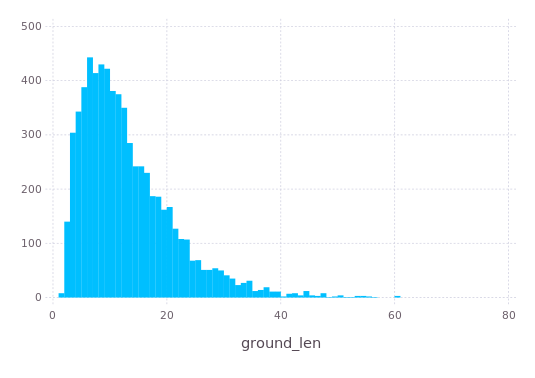

Mean:         12.580201
Minimum:      1.000000
1st Quartile: 7.000000
Median:       11.000000
3rd Quartile: 17.000000
Maximum:      60.000000


In [46]:
bag_res[:ground_len] |> describe 
p=Gadfly.plot(bag_res, x="ground_len",  Geom.histogram)
#draw(PNG("brown_length_dist.png", 24cm, 6cm), p)

In [ ]:
`git add ../../documents_prepared/Journal\ Papers/SumResynthesis/data/ordering_scores.csv` |> run
`git commit -m="new results` |> run
`git push` |> run

In [ ]:
##############################################
# ORDERED
########################################

In [47]:
using PyCall
@pyimport nltk
@pyimport nltk.align.bleu_score as nltk_bleu

function bleu_score(candidate, reference)
    reference = reference |> collect
    candidate = candidate |> collect
    
    if reference==candidate #Perfect Match
        1.0
    else
        weights = [1,1,1,1]/4
        nltk_bleu.bleu(candidate,Any[reference], weights)
    end
end

/usr/local/lib/python2.7/dist-packages/nltk/app/__init__.py:29: UserWarning: nltk.app package not loaded (please install Tkinter library).
  warnings.warn("nltk.app package not loaded "
/usr/local/lib/python2.7/dist-packages/nltk/draw/__init__.py:15: UserWarning: nltk.draw package not loaded (please install Tkinter library).
  warnings.warn("nltk.draw package not loaded "


bleu_score (generic function with 1 method)

In [48]:
bleu_score(["the","comedy","of","manners","of","this","first","a","basis","is","performed","in","1892","."],
           ["this","is","the" ,"basis","of","a" ,"comedy" ,"of","manners","first","performed","in","1892", "."]
)

0.30576902884505114

In [49]:
immutable OrderRecord{T}
    reference::Vector{T}
    actual::Vector{T}
    prob::Float64
    time::Float64
    status::Symbol
end

In [172]:
function load_ordering_results(path, keys)
    blocked_records = Dict{Int,Any}([key=>load(path,string(key)) for key in keys])
    @pipe blocked_records |> flatten_blocked_records |> map(r->OrderRecord(r...),_)
end

books_0_001 = load_ordering_results("results/ordered/books_corpus_0.001_of_test_glove300.jld", 1:100)
books_0_001_oracle = load_ordering_results("results/ordered/books_corpus_0.001_of_test_oracle.jld", 1:100)

6677-element Array{OrderRecord{Symbol},1}:
 OrderRecord{Symbol}([symbol("``"),:you,:would,:destroy,:a,:book,:that,:even,:the,:quran,:calls,:holy,:?,symbol("''")],[symbol("``"),:a,:book,:would,:destroy,:even,:the,:holy,:quran,:that,:calls,:you,:?,symbol("''")],1.592581939704715e-30,15.778937717,:Optimal)                                                                      
 OrderRecord{Symbol}([:im,:glad,:that,:i,:left,:henderson,:.],[:im,:glad,:that,:i,:left,:henderson,:.],2.6698676199888008e-14,6.937845896,:Optimal)                                                                                                                                                                                        
 OrderRecord{Symbol}([:he,:ran,:around,:the,:student,:apartments,:yelling,:fire,symbol(","),:fire,:!],[:he,:ran,:around,:the,:student,:apartments,symbol(","),:yelling,:fire,:fire,:!],1.499813408111198e-29,10.936284901,:Optimal)                                                                  

In [68]:
attempted_only{T<:OrderRecord}(recs::Vector{T}) = filter(r->r.status!=:NotAttempted, recs)
feasible_only{T<:OrderRecord}(recs::Vector{T}) = filter(r->r.status!=:Infeasible, recs)


feasible_only (generic function with 1 method)

In [69]:
function exact_match(rec::OrderRecord)
    rec.reference == rec.actual
end
function bleu_score(rec::OrderRecord)
    bleu_score( rec.actual, rec.reference)
end

bleu_score (generic function with 2 methods)

In [235]:
function get_ordering_res(;datas...)
    @pz datas
    ordering_res = DataFrame(Models=map(kw->kw[1],datas))
    
    methods = [
        (:Time_taken, data -> mean(map(r->r.time , data|> attempted_only))),
        (:BLEU_Score, data ->     mean(map(bleu_score,  data|> attempted_only))),
        (:Exact_Matches, data ->  mean(map(exact_match, data|> attempted_only))),
        (:Feasible, data ->     mean(map(r->r.status==:Optimal, data|> attempted_only))),
        (:Exact_Matches_Feasible_only, data ->  mean(map(exact_match, data|> attempted_only |>feasible_only))),
        (:BLEU_Score_feasible_only, data ->     mean(map(bleu_score,  data|> attempted_only |>feasible_only) )),
    ]
    
    for (method, fn) in methods
        ordering_res[method]=[fn(data) for (model, data) in datas]
    end
    ordering_res
end

ordering_res = get_ordering_res(books_0_001=books_0_001, books_0_001_oracle=books_0_001_oracle)
round_tbl(ordering_res)

datas		

,Models,Time_taken,BLEU_Score,Exact_Matches,Feasible,Exact_Matches_Feasible_only,BLEU_Score_feasible_only
1,books_0_001,6.91,0.75,0.62,0.94,0.66,0.8
2,books_0_001_oracle,6.81,0.81,0.67,0.99,0.67,0.81


Array{Any,1}	(2,)


In [236]:
function mean_by_length{T<:OrderRecord}(rater::Function, data::Vector{T})
    groups = groupby_value(r->length(r.reference), data) 
    @assert symdiff(keys(groups),1:length(groups))|> length ==0
    [mean(map(rater,groups[len])) for len in 1:length(groups)]
end
function get_instance_counts(data)
    groups = groupby_value(r->length(r.reference), data) 
    [length(groups[sent_len]) for sent_len in sort(collect(keys(groups)))]
end

function get_ordering_length_res(data)
    ordering_length_res = DataFrame(ground_length=1:maximum([length(r.reference) for r in data |> attempted_only]),
    Instances = get_instance_counts(data|> attempted_only),
    Time_taken = mean_by_length(r->r.time , data|> attempted_only),
    BLEU_Score    =  mean_by_length(bleu_score,  data|> attempted_only),
    Exact_Matches =  mean_by_length(exact_match, data|> attempted_only),    
    Feasible      =  mean_by_length(r->r.status==:Optimal, data|> attempted_only),
    Exact_Matches_Feasible_only =  mean_by_length(exact_match, data|> attempted_only |>feasible_only),
    BLEU_Score_feasible_only    =  mean_by_length(bleu_score,  data|> attempted_only |>feasible_only) 
    )
end
#writetable(OUTPUT_DIR*"ordering_scores.csv", ordering_res)
ordering_length_res = get_ordering_length_res(books_0_001)
round_tbl(ordering_length_res)

,ground_length,Instances,Time_taken,BLEU_Score,Exact_Matches,Feasible,Exact_Matches_Feasible_only,BLEU_Score_feasible_only
1,1,8.0,0.04,1.0,1.0,1.0,1.0,1.0
2,2,140.0,0.05,1.0,1.0,1.0,1.0,1.0
3,3,304.0,0.09,0.97,0.97,0.98,0.98,0.98
4,4,343.0,0.2,0.95,0.95,0.99,0.96,0.96
5,5,388.0,0.33,0.89,0.89,0.98,0.91,0.91
6,6,443.0,0.52,0.88,0.87,1.0,0.88,0.89
7,7,414.0,0.79,0.85,0.82,0.99,0.83,0.86
8,8,430.0,1.19,0.81,0.73,0.98,0.74,0.82
9,9,422.0,1.64,0.78,0.69,0.98,0.71,0.79
10,10,381.0,2.54,0.73,0.58,0.96,0.61,0.77


In [237]:
ordering_length_res_oracle = get_ordering_length_res(books_0_001_oracle)
round_tbl(ordering_length_res_oracle)

,ground_length,Instances,Time_taken,BLEU_Score,Exact_Matches,Feasible,Exact_Matches_Feasible_only,BLEU_Score_feasible_only
1,1,8.0,0.05,1.0,1.0,1.0,1.0,1.0
2,2,140.0,0.05,1.0,1.0,1.0,1.0,1.0
3,3,304.0,0.11,0.98,0.98,0.98,0.98,0.98
4,4,343.0,0.21,0.96,0.96,0.99,0.96,0.96
5,5,388.0,0.36,0.92,0.92,0.98,0.92,0.92
6,6,443.0,0.57,0.89,0.88,1.0,0.88,0.89
7,7,414.0,0.88,0.88,0.85,1.0,0.85,0.88
8,8,430.0,1.28,0.84,0.78,1.0,0.78,0.84
9,9,422.0,1.75,0.81,0.73,0.99,0.72,0.81
10,10,381.0,2.63,0.8,0.65,1.0,0.65,0.8


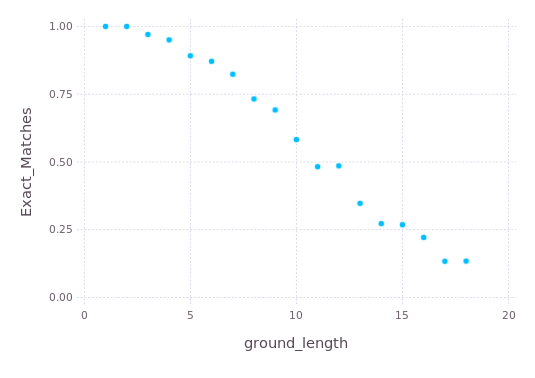

In [242]:
Gadfly.plot(ordering_length_res, x=:ground_length, y=:Exact_Matches)

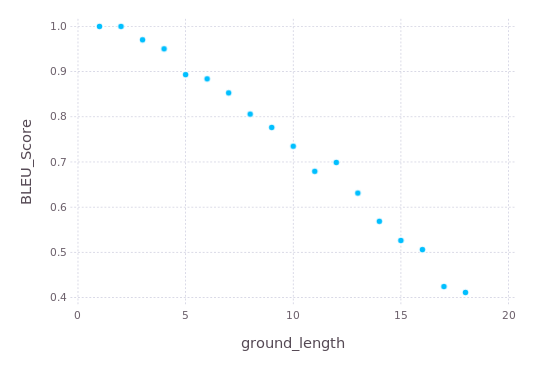

In [241]:
Gadfly.plot(ordering_length_res, x=:ground_length, y=:BLEU_Score)

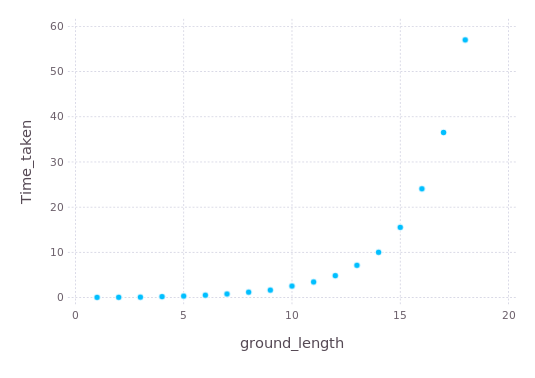

In [125]:
Gadfly.plot(ordering_length_res, x=:ground_length, y=:Time_taken)

In [167]:
function cum_means(indexed_data::DataFrame, index_col=:ground_length, count_col=:Instances)
    @assert issorted(indexed_data[index_col])
    cum_data=DataFrame()
    cum_data[Symbol("max_"*string(index_col))] = indexed_data[index_col]
    cum_data[count_col] = cumsum(indexed_data[count_col])
    keep_cols = @pipe indexed_data.colindex |> keys |> collect |> filter(col->col∉[index_col, count_col], _) |> collect
    for col in keep_cols
        total_count = 0
        total_score = 0
        prev_index = 0 
        function cum(ii)
            @assert ii>prev_index
            score = indexed_data[ii,col]
            count = indexed_data[ii,count_col]
            total_score = (total_score*total_count+score*count)/(total_count+count)
            total_count+=count
            prev_index = ii
            return total_score
        end
        cum_data[col]= map(cum, 1:length(indexed_data[col]))
    end
    cum_data
end
    

cum_means (generic function with 3 methods)

In [168]:
cum_means(ordering_length_res)

,max_ground_length,Instances,Time_taken,BLEU_Score,Exact_Matches,Feasible,Exact_Matches_Feasible_only,BLEU_Score_feasible_only
1,1,8,0.037196984625000006,1.0,1.0,1.0,1.0,1.0
2,2,148,0.05161132330405405,1.0,1.0,1.0,1.0,1.0
3,3,452,0.07411717935176994,0.9800884955752213,0.9800884955752213,0.9845132743362832,0.9841482673341081,0.9841482673341081
4,4,795,0.12799627182767295,0.9672955974842767,0.9672955974842767,0.9861635220125786,0.9744422949743816,0.9744422949743816
5,5,1183,0.19262108031191882,0.9430387051166115,0.9425190194420964,0.9839391377852916,0.9526160459842522,0.9531466724098095
6,6,1626,0.2817039658487085,0.926947689021352,0.9231242312423125,0.9870848708487084,0.9315469552846214,0.93539399824415
7,7,2040,0.38443040316470584,0.9119227097295868,0.9029411764705882,0.9872549019607844,0.9116980654163106,0.920770940391618
8,8,2470,0.5243898278967611,0.8934738027439681,0.8732793522267206,0.9866396761133603,0.8826221940917897,0.903103516239613
9,9,2892,0.6875629524823651,0.8763993166498085,0.8468188105117566,0.9854771784232366,0.8569986222450305,0.8870928938325896
10,10,3273,0.9031117207445768,0.8599246388826883,0.8160708829819737,0.9822792545065689,0.8280389619254334,0.873029206835805


In [150]:
"results/bags/"

7

In [131]:
delete!()

search: 

```
delete!(collection, key)
```

Delete the mapping for the given key in a collection, and return the collection.


delete! deleteat! deleterows! o_delete ordering_length_res



In [ ]:
########

In [ ]:
fold_indexes=load("brown_glove_folds.jld","fold_indexes");

In [ ]:
function fold(data, fold_indexes)
    ret = Dict()
    for (fold_number,fold_iis) in enumerate(fold_indexes)
        ret["fold_$(fold_number)"] = data[fold_iis]
    end
    ret
end

In [ ]:
jaccard_folds_300 = fold(bag_res[:glove300_jaccard], fold_indexes)

In [ ]:
[jaccard_folds_300["fold_6"] bleu_scores300[1]]

In [ ]:
get_bleu_score(folds300,  count_give_ups=true, count_nonattepts=true);